In [1]:
#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

import numpy as np
import pandas as pd  
import gensim#For topic modeling
import lucem_illud

#access lda model
import logging
import pyLDAvis.gensim
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

now_df = pd.read_table('data/sample.txt' ,header=0, encoding='gb2312', sep=',') 
now_df

,id,text,month,year
0,1705816,"For those of us who have not known war , the ...",11,10
1,4512620,"Kazi Khaleed Ashraf ONCE upon a time , Dhak...",3,10
2,1448476,There is a myth in wide circulation that the ...,4,10
3,1490802,Please turn on JavaScript . Media requires Ja...,5,10
4,1647381,Image caption The death of Mono Jojoy could c...,9,10
...,...,...,...,...
45425,31034526,Can an academic study also double up as a riv...,6,19
45426,50673735,"Glasgow Southside , where Nicola Sturgeon is ...",5,19
45427,31262587,"Rabbi Joachim Prinz , second from the left , ...",9,19
45428,50662844,The global rate of species extinction is ten ...,5,19


In [2]:
now_df = now_df.dropna(axis = 0)

In [3]:
#randomly sample 2 news from each year
#now_df = now_df.groupby('year').apply(lambda x: x.sample(400, random_state = 123)).reset_index(drop=True)
#now_df

In [4]:
#now_df.to_csv("data/small_sample.txt", index=False)

In [5]:
#initialize
nowTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
nowTFVects = nowTFVectorizer.fit_transform(now_df['text'])

In [6]:
now_df['tokenized_text'] = now_df['text'].apply(lambda x: lucem_illud.word_tokenize(x))
now_df['normalized_tokens'] = now_df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [7]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

now_df['reduced_tokens'] = now_df['normalized_tokens'].apply(lambda x: dropMissing(x, nowTFVectorizer.vocabulary_.keys()))

In [8]:
dictionary = gensim.corpora.Dictionary(now_df['reduced_tokens'])

In [9]:
corpus = [dictionary.doc2bow(text) for text in now_df['reduced_tokens']]

In [10]:
gensim.corpora.MmCorpus.serialize('data/now.mm', corpus)
nowmm = gensim.corpora.MmCorpus('data/now.mm')

In [11]:
nowlda = gensim.models.ldamodel.LdaModel(corpus=nowmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [12]:
ldaDF = pandas.DataFrame({
        'id' : now_df['id'],
        'year' : now_df['year'],
        'topics' : [nowlda[dictionary.doc2bow(l)] for l in now_df['reduced_tokens']]
    })

In [13]:
ldaDF

,id,year,topics
0,1705816,10,"[(0, 0.46789294), (3, 0.05461513), (5, 0.10503..."
1,4512620,10,"[(5, 0.17833693), (7, 0.3979442), (9, 0.4194473)]"
2,1448476,10,"[(0, 0.714647), (9, 0.28103396)]"
3,1490802,10,"[(1, 0.108608775), (3, 0.16591899), (5, 0.3892..."
4,1647381,10,"[(1, 0.23715556), (3, 0.6763715), (9, 0.081746..."
...,...,...,...
45425,31034526,19,"[(2, 0.16891086), (3, 0.41919085), (4, 0.01667..."
45426,50673735,19,"[(1, 0.025462797), (4, 0.15318277), (7, 0.6069..."
45427,31262587,19,"[(1, 0.0361597), (3, 0.17191525), (4, 0.446679..."
45428,50662844,19,"[(0, 0.18092419), (3, 0.36152542), (5, 0.10246..."


In [14]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(nowlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(nowlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

In [15]:
#randomly sample 2 news from each year
df = ldaDF.groupby('year').apply(lambda x: x.sample(2, random_state = 123)).reset_index(drop=True)
df

,id,year,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,1563224,10,"[(0, 0.4312536), (1, 0.3387448), (4, 0.0606277...",0.431254,0.338745,0.000000,0.000000,0.060628,0.043584,0.000000,0.123570,0.000000,0.000000
1,1451590,10,"[(1, 0.17420802), (3, 0.6134578), (8, 0.015268...",0.000000,0.174208,0.000000,0.613458,0.000000,0.000000,0.000000,0.000000,0.015268,0.195263
2,4111108,11,"[(0, 0.077267244), (3, 0.04065723), (9, 0.8798...",0.077267,0.000000,0.000000,0.040657,0.000000,0.000000,0.000000,0.000000,0.000000,0.879876
3,4244553,11,"[(4, 0.02725928), (5, 0.016135849), (8, 0.7298...",0.000000,0.000000,0.000000,0.000000,0.027259,0.016136,0.000000,0.000000,0.729813,0.225441
4,1237839,12,"[(2, 0.28756532), (3, 0.10317103), (4, 0.44643...",0.000000,0.000000,0.287565,0.103171,0.446434,0.000000,0.000000,0.155893,0.000000,0.000000
5,830162,12,"[(1, 0.18145803), (3, 0.16915679), (5, 0.23545...",0.000000,0.181458,0.000000,0.169157,0.000000,0.235459,0.000000,0.082334,0.044218,0.285575
6,561358,13,"[(1, 0.4414811), (4, 0.33261058), (7, 0.216235...",0.000000,0.441481,0.000000,0.000000,0.332611,0.000000,0.000000,0.216236,0.000000,0.000000
7,2027451,13,"[(1, 0.06298716), (3, 0.5324159), (4, 0.225255...",0.000000,0.062987,0.000000,0.532416,0.225256,0.000000,0.000000,0.000000,0.000000,0.176567
8,4615147,14,"[(0, 0.03836064), (3, 0.95892245)]",0.038361,0.000000,0.000000,0.958922,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,2307789,14,"[(1, 0.3021243), (2, 0.043693945), (5, 0.65188...",0.000000,0.302124,0.043694,0.000000,0.000000,0.651888,0.000000,0.000000,0.000000,0.000000


In [16]:
ldaDFV = df[['topic_%d' %x for x in range(10)]]
ldaDFVisN = df[['year']]
ldaDFVis = ldaDFV.values
ldaDFVisNames = ldaDFVisN.values
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.431254,0.338745,0.000000,0.000000,0.060628,0.043584,0.000000,0.123570,0.000000,0.000000
1,0.000000,0.174208,0.000000,0.613458,0.000000,0.000000,0.000000,0.000000,0.015268,0.195263
2,0.077267,0.000000,0.000000,0.040657,0.000000,0.000000,0.000000,0.000000,0.000000,0.879876
3,0.000000,0.000000,0.000000,0.000000,0.027259,0.016136,0.000000,0.000000,0.729813,0.225441
4,0.000000,0.000000,0.287565,0.103171,0.446434,0.000000,0.000000,0.155893,0.000000,0.000000
5,0.000000,0.181458,0.000000,0.169157,0.000000,0.235459,0.000000,0.082334,0.044218,0.285575
6,0.000000,0.441481,0.000000,0.000000,0.332611,0.000000,0.000000,0.216236,0.000000,0.000000
7,0.000000,0.062987,0.000000,0.532416,0.225256,0.000000,0.000000,0.000000,0.000000,0.176567
8,0.038361,0.000000,0.000000,0.958922,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.302124,0.043694,0.000000,0.000000,0.651888,0.000000,0.000000,0.000000,0.000000


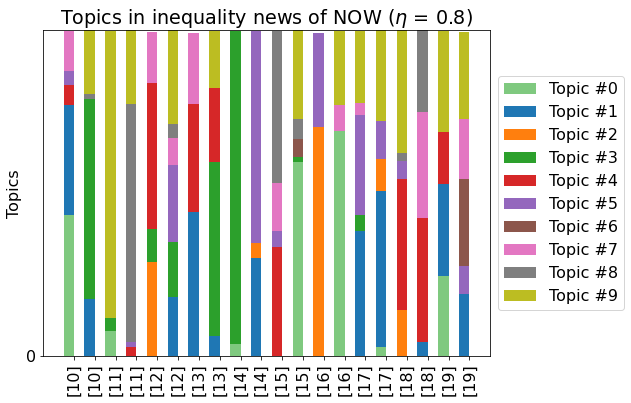

In [17]:
N = 20
ind = np.arange(N)
K = nowlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)
plt.rc('font', size=16)
plt.figure(figsize = (8, 6))

for k in range(K):
    color = plt.cm.Accent(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in inequality news of NOW ($\eta$ = 0.8)')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

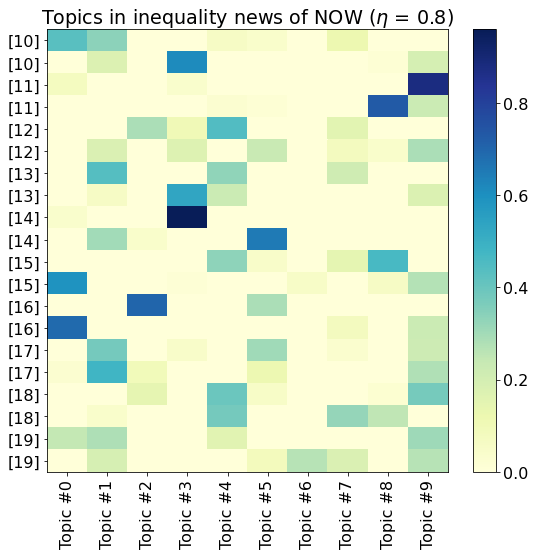

In [18]:
plt.figure(figsize = (8,8))
plt.pcolor(ldaDFVis, norm=None, cmap='YlGnBu')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);
plt.title('Topics in inequality news of NOW ($\eta$ = 0.8)')
# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='YlGnBu')
plt.tight_layout()  # fixes margins
plt.show()

In [19]:
topicsDict = {}
for topicNum in range(nowlda.num_topics):
    topicWords = [w for w, p in nowlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,tax,say,woman,state,pay,change,south,say,school,think
1,economy,party,gender,right,work,need,africa,city,education,know
2,business,president,man,india,wage,say,african,income,student,come
3,economic,trump,say,political,job,work,anc,house,university,work
4,growth,election,work,development,income,community,land,cent,child,thing
5,market,vote,female,social,labour,use,black,report,say,say
6,policy,state,equality,economic,low,think,africans,high,high,way
7,bank,campaign,violence,human,union,information,national,poverty,work,want
8,company,political,child,power,increase,way,economic,percent,college,live
9,investment,mr,sexual,nation,minimum,comment,need,health,study,day


<Figure size 432x288 with 0 Axes>

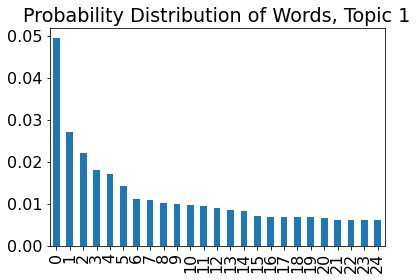

In [20]:
topic1_df = pandas.DataFrame(nowlda.show_topic(1, topn=25))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

<Figure size 432x288 with 0 Axes>

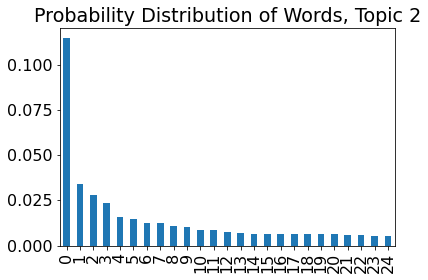

In [21]:
topic_df = pandas.DataFrame(nowlda.show_topic(2, topn=25))
plt.figure()
topic_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 2')
plt.show()

𝛼  controls the sparsity of document-topic loadings, and 𝜂 controls the sparsity of topic-word loadings.

In [ ]:
um = []
cv = []
p = []
for num_topics in range(2,16):
    print(num_topics)
    nowlda1 = gensim.models.ldamodel.LdaModel(corpus=nowmm, id2word=dictionary, num_topics=num_topics, alpha = 0.5, eta = 0.01)
    cm_u_mass = CoherenceModel(model=nowlda1, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    #pyLDAvis.enable_notebook()
    #pyLDAvis.gensim.prepare(nowlda1, corpus, dictionary)
    um.append(cm_u_mass.get_coherence())
    cm_c_v = CoherenceModel(model=nowlda1, texts=now_df["reduced_tokens"], dictionary=dictionary, coherence='c_v')
    cv.append(cm_c_v.get_coherence())
    p.append(nowlda1.log_perplexity(corpus))

In [ ]:
access_df = pandas.DataFrame(range(2, 16), columns=['num_topics'])

In [ ]:
access_df = pandas.concat([access_df, pandas.DataFrame(um, columns=['u_mass'])],axis=1)

In [ ]:
access_df = pandas.concat([access_df, pandas.DataFrame(cv, columns=['c_v'])],axis=1)

In [ ]:
access_df = pandas.concat([access_df, pandas.DataFrame(p, columns=['perplexity'])],axis=1)

In [ ]:
access_df

In [28]:
nowlda.log_perplexity(nowmm)

-6.054358504114042

# Hyperparameter Tuning

In [29]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b): 
    #nowlda1 = gensim.models.ldamodel.LdaModel(corpus=nowmm, id2word=dictionary, num_topics=num_topics, alpha = 0.5, eta = 0.01)
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           #random_state=100,
                                           #chunksize=100,
                                           #passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=now_df["reduced_tokens"], dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [30]:
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 16
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(nowmm, int(num_of_docs*0.75)), 
               nowmm]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=840)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

840it [30:20:04, 130.01s/it]                                                                                           


In [31]:
um

[-0.7910421907975892,
 -0.8724999085011503,
 -0.8616420912865195,
 -0.9157395316264848,
 -0.95696638252219,
 -0.9073375749098085,
 -0.9855011218236502,
 -1.0230714449433984,
 -1.0368869385938564,
 -1.0674393652951546,
 -1.0520664930523667,
 -1.0377891426365269,
 -1.1258629424200808,
 -1.0330468969570403]

In [32]:
cv

0.28862364099364846

In [33]:
#topic11_df = pandas.DataFrame(nowlda1.show_topic(1, topn=50))
#topic21_df = pandas.DataFrame(nowlda2.show_topic(1, topn=50))

#fig, (ax1, ax2) = plt.subplots(1, 2)
#fig.set_size_inches(18, 7)
#topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.01')
#topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
#plt.show()

# evaluate lda model

In [34]:
#logger = logging.getLogger()
#logger.setLevel(logging.DEBUG)
#logging.debug("test")

In [71]:
nowlda1 = gensim.models.ldamodel.LdaModel(corpus=nowmm, id2word=dictionary, num_topics=7, alpha = "asymmetric", eta = .31)

In [72]:
cm = CoherenceModel(model=nowlda1, corpus=corpus, dictionary=dictionary, coherence='u_mass')

In [73]:
#print(cm)

In [74]:
pyLDAvis.enable_notebook()

In [75]:
pyLDAvis.gensim.prepare(nowlda1, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.147832  0.066438       1        1  17.570420
4     -0.027578  0.089113       2        1  17.316696
2      0.074329 -0.078463       3        1  14.610292
0     -0.081089  0.055247       4        1  14.380229
1     -0.068835 -0.003521       5        1  14.303541
6      0.033562 -0.065936       6        1  12.425372
5     -0.078221 -0.062878       7        1   9.393448, topic_info=         Term           Freq          Total Category  logprob  loglift
393     woman  101438.000000  101438.000000  Default  30.0000  30.0000
355     party   52354.000000   52354.000000  Default  29.0000  29.0000
610       tax   48532.000000   48532.000000  Default  28.0000  28.0000
609     south   50247.000000   50247.000000  Default  27.0000  27.0000
578    income   49108.000000   49108.000000  Default  26.0000  26.0000
..        ...            ...            ...      ...      ...      ...
166  national    7117.738311   48812.516522   Topic7  -5.0364   0.4398
502    report    6228.520470   49659.717369   Topic7  -5.1699   0.2891
178     right    6524.694974   68977.980343   Topic7  -5.1234   0.0070
21       come    6054.842265   60227.031468   Topic7  -5.1982   0.0679
384      tell    5511.430965   33889.971883   Topic7  -5.2922   0.5489

[385 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
503       1  0.012142  abuse
503       2  0.043496  abuse
503       3  0.062843  abuse
503       4  0.607479  abuse
503       5  0.055238  abuse
...     ...       ...    ...
656       3  0.529339   zuma
656       4  0.000231   zuma
656       5  0.002540   zuma
656       6  0.000231   zuma
656       7  0.467444   zuma

[2022 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 1, 2, 7, 6])

In [76]:
print(cm.get_coherence())

-0.9416803810611282


In [77]:
#
goodcm = CoherenceModel(model=nowlda1, texts=now_df["reduced_tokens"], dictionary=dictionary, coherence='c_v')

In [78]:
#print(goodcm)

In [79]:
print(goodcm.get_coherence())

0.4213794729406689
